In [3]:
import random
import time

from string import ascii_lowercase

import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Optionally use MPS (M1 GPU) backend for all tensors by default -> didn't seem to be faster for a basic NN
#torch.set_default_device(torch.device("mps"))

EPS = 1e-7

%matplotlib inline

## Dataset 

In [4]:
# Load file and take only the second column, which is called "city_ascii" - so simple city names
# city_names = [row.split(",")[1].replace('"', "") for row in open("worldcities.csv").readlines()][1:]  #  drop header

# Load file and take only the first column, giving the name in all its glory
city_names = [row.split(",")[0].replace('"', "") for row in open("worldcities.csv").readlines()][1:]  #  drop header
city_names[:10]

# Use code below to only use cities from a specific country
# COUNTRY = "finland"
# city_names = []
# rows = [row for row in open("worldcities.csv").readlines()]
# for row in rows:
#   parts = row.split(",")
#   city = parts[1].replace('"', "")
#   country = parts[4].replace('"', "")
#   if country.lower() != COUNTRY:
#     continue
#   else:
#     print(f"{country} -> {city}")
#   city_names.append(city.lower())
#   #city_names = city_names[1:]  # don't take header row's value
# city_names[:10]


['Tokyo',
 'Jakarta',
 'Delhi',
 'Guangzhou',
 'Mumbai',
 'Manila',
 'Shanghai',
 'São Paulo',
 'Seoul',
 'Mexico City']

In [76]:
# We need a special characters to denote the start and end of a city name
SPACE = " "
start_end_char = "."
# allowed_chars = SPACE + ascii_lowercase  # allow only lowercase letters and space
allowed_chars = SPACE + "".join(sorted(set("".join(city_names))))  # allow all characters that appear in the city names
allowed_chars.replace(".", "")
all_chars = sorted(set(start_end_char + allowed_chars))

print(f"ascii_lowercase: {ascii_lowercase}")
print(f"allowed_chars:   {allowed_chars}")
print(f"all_chars:       {all_chars}")

print()

# Clean up the names a little bit
_cities = [name.strip().lower() for name in city_names]

# Remove characters that we don't want to allow
cities = []
for city in _cities:
    clean_city = "".join(ch for ch in city if ch in allowed_chars)
    # print(city, " -> ", clean_city)
    cities.append(clean_city)

# Include start/end token
# We don't start city names with "." here anymore, as the context block will be filled with them instead
# cities = [start_end_char + city + start_end_char for city in cities]
cities = [city + start_end_char for city in cities]
print(f"Cleaned up cities: {cities[:8]}")

# We will also allow start_end_char
num_classes = len(all_chars)
print(f"\nTotal num valid chars = {num_classes}")

# Create simple mapping between each string char and its integer index
stoi = {c: i for i, c in enumerate(all_chars)}
itos = {i: c for c, i in stoi.items()}

print(f"\n{stoi=}")
print(f"\n{itos=}")


ascii_lowercase: abcdefghijklmnopqrstuvwxyz
allowed_chars:     '()-./234ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÄÅÇÉÍÎÐÑÓÖØÚÜßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýÿĀāăąĆćċČčďĐđĒēĖėęěğĠġĦħĩĪīĭİıĶļĽľŁłńňŌōŎŏőœŘřŚśŞşŠšŢţťũŪūŬŭůųŵźŻżŽžƏơưə̧̱̲̃̄̇̈ḍḐḑḥḨḩḯṅṇṟṣṬṭṯẔẕẖạảẤấầẩậắằẵếệỉịọốồổộớờợủứừửựỳỹ‘’
all_chars:       [' ', "'", '(', ')', '-', '.', '/', '2', '3', '4', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'Â', 'Ä', 'Å', 'Ç', 'É', 'Í', 'Î', 'Ð', 'Ñ', 'Ó', 'Ö', 'Ø', 'Ú', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'Ā', 'ā', 'ă', 'ą', 'Ć', 'ć', 'ċ', 'Č', 'č', 'ď', 'Đ', 'đ', 'Ē', 'ē', 'Ė', 'ė', 'ę', 'ě', 'ğ', 'Ġ', 'ġ', 'Ħ', 'ħ', 'ĩ', 'Ī', 'ī', 'ĭ', 'İ',

In [77]:
def build_dataset(words, block_size=3):
    """Create samples mapping block_size input to target character."""
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [1]:
random.seed(345)
random.shuffle(cities)
num_words = len(cities)
n1 = int(0.8 * num_words)
n2 = int(0.9 * num_words)

WINDOW = 5

Xtr, Ytr = build_dataset(cities[:n1], block_size=WINDOW)  # 80%
Xdev, Ydev = build_dataset(cities[n1:n2], block_size=WINDOW)  # 10%
Xte, Yte = build_dataset(cities[n2:], block_size=WINDOW)  # 10%


NameError: name 'random' is not defined

torch.Size([360826, 5]) torch.Size([360826])
torch.Size([44746, 5]) torch.Size([44746])
torch.Size([45265, 5]) torch.Size([45265])


##  Manual backprop

We will manually compute the gradients for each operation of our example network, which uses `torch.Tensor`s.

Things to watch out for (apart from knowing mathematical expressions of derivatives of our operations):

1. Broadcasting: if a tensor is expanded across another (e.g. in a `mul` op), we must replicate the gradients to also have the expanded impact. This normally means the same broadcasting actually happens in the chain rule update (`dglobal*dlocal`) then just `.sum(1, keepdim=True)`, such that `dlocal.shape==local.shape`

2. Shapes: the shape of a gradient tensor must match the shape of the actual tensor it is describing! Checking these shapes will often also help you find other bugs e.g. where gradients must be summed after broadcasting

3. Branches: look out for tensors that are used as input to multiple other tensors. Here we must compute gradients multiple times. All gradient computations after the inital must accumulate into the initial result!

4. gradient of a `.max()` op is 1.0 -- applied only to elements of the tensor that were selected as max

5. gradient of a `.sum()` op is 1.0 -- applied to the entire tensor

6. Order is important when applying the chain rule to matrix multiplication e.g. through `@`! For the matmul, essentially just need to make shapes work out. The bias needs to be broadcasted and summed correspondingly (usually over dim=0)

7. Backpropagating through a reshape/`.view()` operation simply requires reshaping the incoming derivatives to match the original array shape.

8. for lookup operations into some array e.g. `emb = C[Xb]`,  

> **In general just think "Where does this tensor have impact? Which tensors are its children in the graph?"**

In [ ]:
def compare_gradients(name: str, dt, t) -> None:
    """Compare gradients of two tensors for exactness, or approximate closeness.

    Args:
      name: descriptive name to print results.
      dt: gradients tensor computed by us.
      t:  the equivalent pytorch tensor, which has a `.grad` attribute for comparison.
    """

    exact = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad, atol=1e-6)
    maxdiff = (dt - t.grad).abs().max().item()
    a, b = tuple(dt.shape), tuple(t.shape)
    shapes = f"{a} {b}" if dt.shape == t.grad.shape else f"ERROR: {a} {b}"
    print(
        f"{name:<15} | exact: {str(exact):<5} | approx: {str(approx):<5} |",
        f"maxdiff: {maxdiff:<9.3e} | shapes: {shapes}",
    )


### Model weights

In [ ]:
g = torch.Generator().manual_seed(21474836)

# Create an embedding tensor (latent embedding) for our characters
embedding_dim = 32
h_dim = 640
num_inputs = WINDOW * embedding_dim  # 'window' embeddings per sample + 'embedding_dim' values per embedding

C = torch.randn((num_classes, embedding_dim), generator=g)  # context - character embeddings
# Layer 1
W1 = torch.randn((num_inputs, h_dim), generator=g) * (5 / 3) / (h_dim * WINDOW) ** 0.5  # (n_inputs, n_neurons)
b1 = torch.randn(h_dim, generator=g) * 0.1  # making non-zero helps introduce entropy
# Layer 2
W2 = torch.randn((h_dim, num_classes), generator=g) * 0.1  # Scale down the values to control logit magnitude
b2 = torch.randn(num_classes, generator=g) * 0.1  # We don't need to add more noise to the init logits

bngain = torch.ones((1, h_dim)) * 0.1 + 0.1
bnbias = torch.zeros((1, h_dim)) * 0.1

bnmean_running = torch.zeros((1, h_dim))
bnstd_running = torch.ones((1, h_dim))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # remove b1
print(f"Total parameters in model: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

# To track stats
losses = []
batches = []

# Create a minibatch
n = 32
ix = torch.randint(0, Xtr.shape[0], size=(n,))
Xb, Yb = Xtr[ix], Ytr[ix]
print(f"Batch shape: {Xb.shape=}, {Yb.shape=}")


### Forward pass

In [ ]:
# Reduced into very small steps that we can backpropagate through one at a time

# Extract emmeddings for the characters
# C.shape = (n_classes, embedding_length)
# Xb.shape = (n, window)
emb = C[Xb]  # (n, window, embedding_length)
# Layer 1
embcat = emb.view(emb.shape[0], -1)
hprebn = embcat @ W1 + b1  # hidden layer before batch norm, before activation  (n, h_dim)
# Batch norm
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)  # (1, h_dim)
bndiff = hprebn - bnmeani  # (n, h_dim)  broadcasts up from hprebn
bndiff2 = bndiff**2  # (n, h_dim)
bnvar = 1 / (n - 1) * bndiff2.sum(0, keepdim=True)  #  (1, h_dim)    Add bias Bessel correction for sample population
bnvar_inv = (bnvar + EPS) ** -0.5  # (1, h_dim)   = 1/std
bnraw = bndiff * bnvar_inv  # (n, h_dim)   This equals (x - xhat)/std
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)  # (n, h_dim)
# Layer 2
logits = h @ W2 + b2  #  (n, h_dim)(h_dim, n_classes) + (n, 1) -> (n, n_classes)
logit_maxes = logits.max(1, keepdim=True).values
logit_norms = logits - logit_maxes  # subtract max for numerical stibility in following call to X.exp()
# Output probabilities
counts = logit_norms.exp()  # (n, n_classes)
counts_sum = counts.sum(1, keepdim=True)  # (n, 1)
counts_sum_inv = counts_sum**-1  # (n, 1)  --  Use **-1 as torch doesn't allow for exact comparison using /
probs = counts * counts_sum_inv  # (n, n_classes)  --> Broadcasting of counts_sum_inv! Be careful during backprop
# Loss
logprobs = probs.log()  # (n, n_classes)
loss = -logprobs[range(n), Yb].mean()  # (1,)

# Reset any gradient computation that was computed - set gradients to zero
for p in parameters:
    p.grad = None

#
for t in [
    emb,
    embcat,
    hprebn,
    bnmeani,
    bndiff,
    bndiff2,
    bnvar,
    bnvar_inv,
    bnraw,
    hpreact,
    h,
    logits,
    logit_maxes,
    logit_norms,
    counts,
    counts_sum,
    counts_sum_inv,
    logprobs,
    probs,
]:
    t.retain_grad()
loss.backward()
print(f"{loss=}")


### Backprop

In [ ]:
# Gradient of the output tensor itself is always 1.0
# logprobs are the input to loss, so that is the first tensor through which we must perform backprop

## loss = -logprobs[range(n), Yb].mean()  # (1,)
# loss = -(a + b + c) / 3    -- we are only taking the mean
# dloss/da = -1/3            -- more generally: -1/n, applied only where there is a prediction i.e. Yb
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n  #  ✅

## logprobs = probs.log()
# dlogprobs/dlogs = 1/probs
dprobs = dlogprobs * 1.0 / probs  #  ✅

## probs = counts * counts_sum_inv  # (n, n_classes) = (n, n_classes) * (n, 1)
# dprobs/dcounts_sum_inv = counts
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True)  #  ✅ Impact of counts_sum_inv is spread over n_classes!
# We therefore must accumulate gradients across the (expanded) broadcasted dimension to fully capture its impact.

# dprobs/dcounts = counts_sum_inv
dcounts = dprobs * counts_sum_inv  #  ✅
# NOTE: counts is also used in another branch; calculating counts_sum_inv & counts_sum!
# NOTE: We need to accumulate the gradients here over all branches in the graph!

# counts_sum_inv = counts_sum**-1   # (n, 1)
# dcount_sum_inv/dcounts_sum = -counts_sum**-2   # (n, 1)
dcounts_sum = dcounts_sum_inv * (-(counts_sum**-2))  #  ✅

# counts_sum = counts.sum(1, keepdim=True)   # (n, 1)
# # counts = (a, b, c, d)  ->  counts_sum = a+b+c+d  ->  dcounts_sum/da = 1
# dcounts_sum/dcounts = 1.0
dcounts += dcounts_sum * 1.0  #  ✅

# counts = logit_norms.exp()
# dcounts/dlogits = logit_norms.exp() == counts
dlogit_norms = dcounts * counts  #  ✅

# logit_norms = logits - logit_maxes
# dlogit_norms/dlogits = 1.0
# dlogit_norms/dlogit_maxes = -1.0
dlogits = dlogit_norms * 1.0
dlogit_maxes = (dlogit_norms * (-1.0)).sum(1, keepdim=True)  #  ✅ logit_maxes broadcasted across dlogit_norms: accum

# logit_maxes = logits.max(1, keepdim=True).values
# dlogit_maxes/dlogits = 1.0  -- only where we actually selected the logit values, zero everywhere else
ix = logits.max(1).indices
dlogits[range(n), ix] += dlogit_maxes.squeeze()  #  ✅
# Andrej's alternative:
# dlogits += F.one_hot(logits.max(1).indices, num_classes) * dlogit_maxes

## logits = h @ W2 + b2  #  (n, h_dim)(h_dim, n_classes) + (n, 1) -> (n, n_classes)
# dlogits/dh = W2
# dh = dL/dlogits * dlogits/dh
dh = dlogits @ W2.T  #  ✅  # (n, h_dim) = (n, n_classes)(h_dim, n_classes).T
# dlogits/dW2 = h
# dW2 = dL/dlogits * dlogits/dW2
dW2 = h.T @ dlogits  #  ✅  # (h_dim, n_classes) = (n, h_dim).T(n, n_classses)
# dlogits/db2 = 1.0
# db2 = dL/dlogits * dlogits/db2
db2 = (dlogits * 1.0).sum(0, keepdim=False)  #  ✅

# h = torch.tanh(hpreact)
# dh/dhpreact = 1 - torch.tanh(hpreact)**2 == (1 - h**2)
dhpreact = dh * (1 - h**2)

## hpreact = bngain * bnraw + bnbias
# dhpreact/dbngain = bnraw
dbngain = (dhpreact * bnraw).sum(0, keepdim=True)  #  ✅
# dhpreact/dbnraw = bngain
dbnraw = dhpreact * bngain  #  ✅
# dhpreact/dbbias = 1.0
dbnbias = (dhpreact * 1.0).sum(0, keepdim=True)  #  ✅

## bnraw = bndiff * bnvar_inv  # (n, h_dim)   This equals (x - xhat)/std
# dbnraw/dbndiff = bnvar_inv
dbndiff = dbnraw * bnvar_inv  #  ✅  # This will be further accumulated to, from other branches
# dbnraw/dbnvar_inv = bndiff
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)  #  ✅

# bnvar_inv = (bnvar + EPS)**-0.5   # (1, h_dim)   = 1/std
# dbnvar_inv/dbnvar = -0.5 * 1 * (bnvar + EPS)**-1.5
dbnvar = dbnvar_inv * (-0.5 * (bnvar + EPS) ** -1.5)  #  ✅

# bnvar = 1/(n-1) * bndiff2.sum(0, keepdim=True) #  (1, h_dim)    Add bias Bessel correction for sample population
# dbnvar/dbndiff2 = (1/(n-1)) * 1.0  ->  keep shape in mind: torch.ones_like(bndiff2))
dbndiff2 = dbnvar * (1 / (n - 1) * torch.ones_like(bndiff2))  #  ✅

# bndiff2 = bndiff**2  # (n, h_dim)
# dbndiff2/dbndiff = 2*bndiff
dbndiff += dbndiff2 * (2 * bndiff)  #  ✅

# bndiff = hprebn - bnmeani  # (n, h_dim) = (n, h_dim)(1, h_dim) broadcasts up from hprebn
# dbndiff/dhprebn =   1.0
dhprebn = dbndiff * 1.0  #  ✅    #  also flows into another branch so must be accumulated!
# dbndiff/dbnmeani = -1.0
dbnmeani = (dbndiff * -1.0).sum(0, keepdim=True)  #  ✅

# bnmeani = 1/n * hprebn.sum(0, keepdim=True)  # (1, h_dim)
# dbnmeani/dhprebn = 1/n  # but keep shapes in mind!
# Multiplying by 1.0 or torch.ones_like(hprebn) both work as we're adding into the existing dhprebn
# That already has the correct dimensions and so broadcast correctly at that point.
dhprebn += dbnmeani * 1 / n * 1.0  # torch.ones_like(hprebn)   #  ✅

## hprebn = embcat @ W1 + b1  # hidden layer before batch norm, before activation  (n, h_dim)
# dhprebn/dembcat = W1
dembcat = dhprebn @ W1.T  #  ✅
# dhprebn/dW1 = embcat
dW1 = embcat.T @ dhprebn  #  ✅
# dhprebn/db1 = 1.0
db1 = (dhprebn * 1.0).sum(0)  #  ✅

# embcat = emb.view(emb.shape[0], -1)
# dembcat/demb = emb
demb = dembcat.view(emb.shape)  #  ✅

# emb = C[Xb]  # (n, window, embedding_length)
# demb/dC = C[Xb]

##### Andrej's version: 1.3ms #####
# for i in range(Xb.shape[0]):
#   for j in range(Xb.shape[1]):
#     ix = Xb[i, j]
#     dC[ix] += demb[i, j]
#     ec[ix] += 1

##### My version: 60µs #####
# comp = (Xb[..., None] == torch.arange(num_classes).view(1, 1, -1))
# m = demb.unsqueeze(0) * comp.permute(2, 0, 1).unsqueeze(-1)
# dC = m.sum((1b, 2)).to(torch.float32)

##### ChatGPT's version: 10µs #####
dC = torch.zeros_like(C)
dC.index_add_(0, Xb.view(-1), demb.view(-1, embedding_dim))
#  ✅
# it fills dC inplace, but also returns the result for some reason


In [ ]:
compare_gradients("logprobs", dlogprobs, logprobs)
compare_gradients("probs", dprobs, probs)
compare_gradients("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
compare_gradients("counts_sum", dcounts_sum, counts_sum)
compare_gradients("counts", dcounts, counts)
compare_gradients("logit_norms", dlogit_norms, logit_norms)
compare_gradients("logit_maxes", dlogit_maxes, logit_maxes)
compare_gradients("logits", dlogits, logits)
compare_gradients("h", dh, h)
compare_gradients("W2", dW2, W2)
compare_gradients("b2", db2, b2)
compare_gradients("hpreact", dhpreact, hpreact)
compare_gradients("bngain", dbngain, bngain)
compare_gradients("bnbias", dbnbias, bnbias)
compare_gradients("bnvar_inv", dbnvar_inv, bnvar_inv)
compare_gradients("bnvar", dbnvar, bnvar)
compare_gradients("bndiff2", dbndiff2, bndiff2)
compare_gradients("bndiff", dbndiff, bndiff)  # accumulated over several branches
compare_gradients("hprebn", dhprebn, hprebn)
compare_gradients("bnmeani", dbnmeani, bnmeani)
compare_gradients("W1", dW1, W1)
compare_gradients("b1", db1, b1)
compare_gradients("embcat", dembcat, embcat)
compare_gradients("emb", demb, emb)
compare_gradients("C", dC, C)


## Simplify derivative of loss

We can manually compute the derivative of $\dfrac{dL}{dl_i}$ on paper.

We see that the mathematical formula simplify many terms to mean the result is just:

$\dfrac{dL}{dl_i} = P_i \hspace{47px}$  where $i = y$

$\dfrac{dL}{dl_i} = P_i - 1  \hspace{20px}$ where $i \neq y$

In [ ]:
## Forward pass manually, as we wrote it:

# logit_maxes = logits.max(1, keepdim=True).values
# logit_norms = logits - logit_maxes  # subtract max for numerical stibility in following call to X.exp()
# # Output probabilities
# counts = logit_norms.exp()  # (n, n_classes)
# counts_sum = counts.sum(1, keepdim=True)  # (n, 1)
# counts_sum_inv = counts_sum**-1   # (n, 1)  --  Use **-1 as torch doesn't allow for exact comparison using /
# probs = counts * counts_sum_inv  # (n, n_classes)  --> Broadcasting of counts_sum_inv! Be careful during backprop
# # Loss
# logprobs = probs.log()  # (n, n_classes)
# loss = -logprobs[range(n), Yb].mean()  # (1,)

## Forward pass using torch:
loss_fast = F.cross_entropy(logits, Yb)
print(f"{loss_fast.item()=}")
print(f"our {loss.item()=}")
print(f"abs difference: {(loss_fast - loss).abs()}")


In [ ]:
# Gradients of the logits (backprop through cross entropy loss)
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1.0
dlogits /= n

compare_gradients("logits", dlogits, logits)

plt.imshow(dlogits.detach(), cmap="gray")
plt.title(r"$\frac{dL}{dl_i}$ - gradient of loss to output of softmax)" + "\n", fontsize=16, c="r")
# Can think of cross entropy pulling down the probabilities of the incorrect elements
# and pull up on the correct position balances out, as the gradients over one sample sum to 1.
print(f"\nSum of gradients over class logits of a single sample: {dlogits[0].sum().item()}")
print("\tA zero sum game!\n")


## Simplify backprop through BatchNorm

In [ ]:
# forward pass

# hprebn = embcat @ W1 + b1  # hidden layer before batch norm, before activation  (n, h_dim)

#### Batch norm  starts here  ####
# bnmeani = 1/n * hprebn.sum(0, keepdim=True)                  # (1, h_dim)
# bndiff = hprebn - bnmeani                                    # (n, h_dim)  broadcasts up from hprebn
# bndiff2 = bndiff**2                                          # (n, h_dim)
# bnvar = 1/(n-1) * bndiff2.sum(0, keepdim=True)               # (1, h_dim) Add Bessel correction for sample popul
# bnvar_inv = (bnvar + EPS)**-0.5                              # (1, h_dim)   = 1/std
# bnraw = bndiff * bnvar_inv                                   # (n, h_dim)   This equals (x - xhat)/std
# hpreact = bngain * bnraw + bnbias

# In a single line   25 microseconds
hpreact_fast = (
    bngain * (hprebn - 1 / n * hprebn.sum(0, keepdim=True)) * (1 / (n - 1) * bndiff2.sum(0, keepdim=True) + EPS) ** -0.5
    + bnbias
)

# Using torch.Tensor methods is actually slower here!  104 microseconds
hpreact_fast2 = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True)) + bnbias

print((hpreact - hpreact_fast).abs().max())
print((hpreact - hpreact_fast2).abs().max())
print((hpreact_fast - hpreact_fast2).abs().max())


## From ~1h:47m  into Lecture 4 Backprop Ninja

### Full derivation

Also see General Notes on ipad

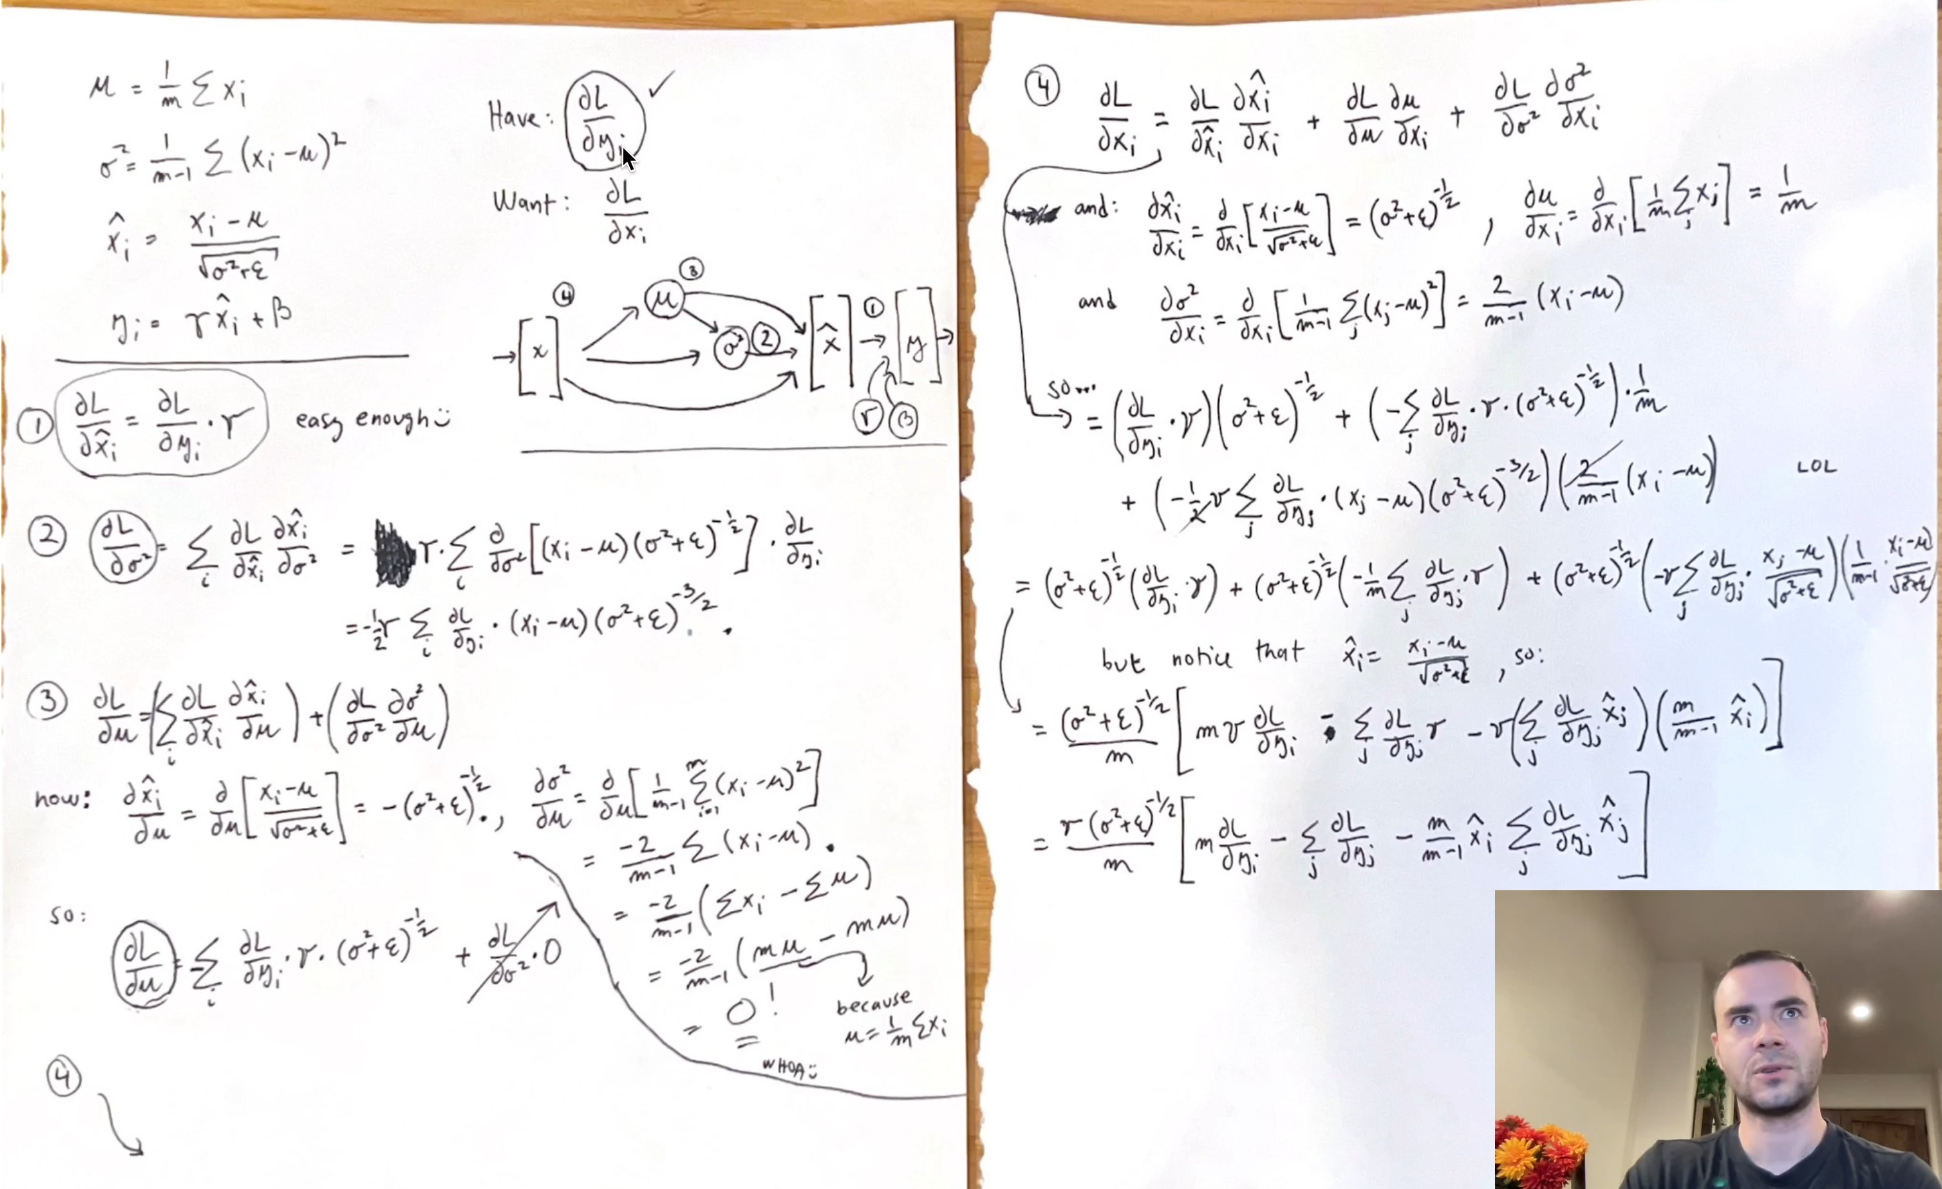

### Oneliner

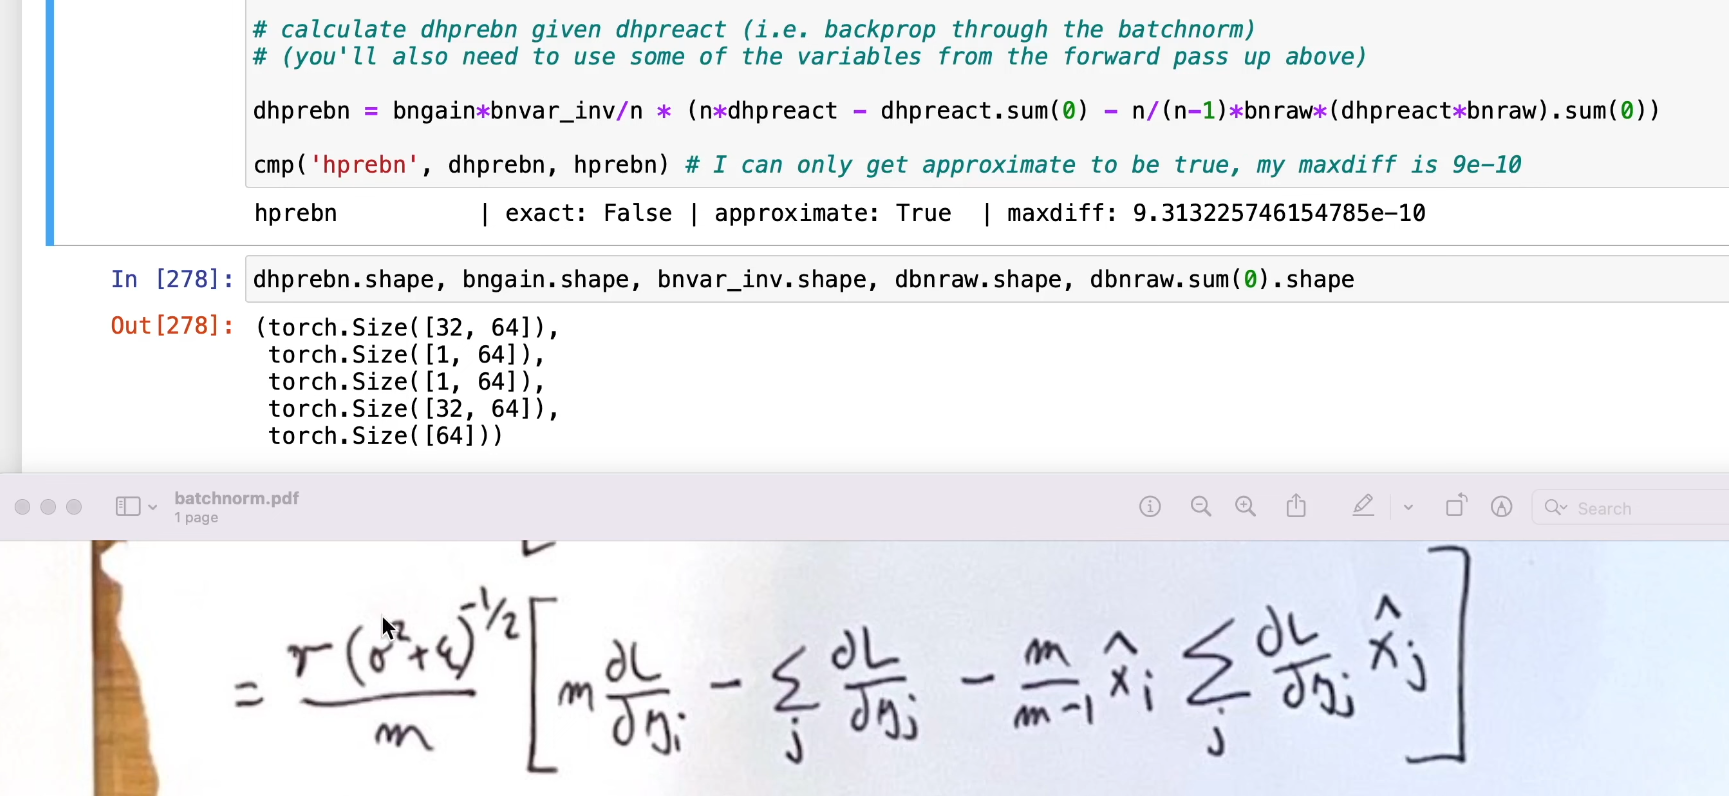

In [ ]:
# Take the oneliner batchnorm backprop from image above:
dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))

compare_gradients("hprebn", dhprebn, hprebn)


## Training with manual backprop, with simplified gradient computation

Total parameters in model: 262475
Batch shape: Xb.shape=torch.Size([64, 5]), Yb.shape=torch.Size([64])

Training...

[     0] loss= 5.6409				Training time:  0m  0s
[ 20000] loss= 2.9046				Training time:  0m 38s
[ 40000] loss= 2.2736				Training time:  1m 16s
[ 60000] loss= 2.3117				Training time:  1m 55s
[ 80000] loss= 2.5894				Training time:  2m 34s
[100000] loss= 2.5719				Training time:  3m 13s
[120000] loss= 1.9545				Training time:  3m 54s
[140000] loss= 2.3569				Training time:  4m 31s
[160000] loss= 2.1828				Training time:  5m  9s
[180000] loss= 2.3779				Training time:  5m 47s
[200000] loss= 2.3776				Training time:  6m 25s
[220000] loss= 2.2398				Training time:  7m  3s
[240000] loss= 2.2495				Training time:  7m 43s
[260000] loss= 2.2035				Training time:  8m 23s
[280000] loss= 2.1803				Training time:  9m  3s
[300000] loss= 2.4737				Training time:  9m 41s
[320000] loss= 2.1937				Training time: 10m 19s
[340000] loss= 1.9216				Training time: 10m 58s
[360000] loss= 2.22

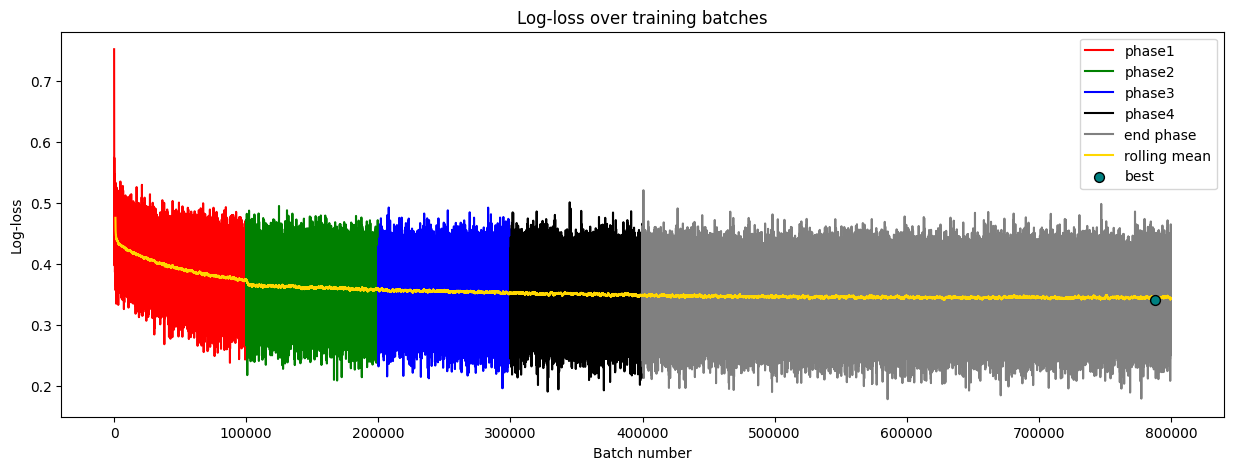

In [9]:
# Model definition ###################################################
g = torch.Generator().manual_seed(214748)

# Create an embedding tensor (latent embedding) for our characters
embedding_dim = 16
h_dim = 640
num_inputs = WINDOW * embedding_dim  # 'window' embeddings per sample + 'embedding_dim' values per embedding

C = torch.randn((num_classes, embedding_dim), generator=g)  # context - character embeddings
# Layer 1
W1 = torch.randn((num_inputs, h_dim), generator=g) * (5 / 3) / (h_dim * WINDOW) ** 0.5  # (n_inputs, n_neurons)
b1 = torch.randn(h_dim, generator=g) * 0.1  # making non-zero helps introduce entropy
# Layer 2
W2 = torch.randn((h_dim, num_classes), generator=g) * 0.1  # Scale down the values to control logit magnitude
b2 = torch.randn(num_classes, generator=g) * 0.1  # We don't need to add more noise to the init logits

bngain = torch.ones((1, h_dim)) * 0.1 + 0.1
bnbias = torch.zeros((1, h_dim)) * 0.1

bnmean_running = torch.zeros((1, h_dim))
bnstd_running = torch.ones((1, h_dim))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"Total parameters in model: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

# To track stats
losses = []
batches = []

# Create a minibatch
n = 64
ix = torch.randint(0, Xtr.shape[0], size=(n,))
Xb, Yb = Xtr[ix], Ytr[ix]
print(f"Batch shape: {Xb.shape=}, {Yb.shape=}")

start_time_s = time.perf_counter()

# Training loop ##################################################

with torch.no_grad():  #  swole doge meme
    print("\nTraining...\n")

    # Minibatch gradient descent
    b = len(batches)
    n_steps = 700_000

    for batch in range(b, b + n_steps):
        # Create a minibatch
        ix = torch.randint(0, Xtr.shape[0], size=(n,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        emb = C[Xb]  # index into the embedding tensor at the position of the (batch) training indices
        # Compute the hidden layer transformation and apply non-linearity
        embcat = emb.view(emb.shape[0], WINDOW * embedding_dim)  # concatenate all the selected embedding vectors
        hprebn = embcat @ W1 + b1

        # Apply batch norm before applying non-linearity -> use epsilon to prevent possible NaNs
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True)
        bnvar_inv = (bnvar + EPS) ** -0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        h_preact = bngain * bnraw + bnbias

        with torch.no_grad():
            # Keeping running values of the batch norms stats
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
            bnstd_running = 0.999 * bnstd_running + 0.001 * torch.sqrt(bnvar)

        h = torch.tanh(h_preact)
        logits = h @ W2 + b2  # produces the output of our final layer (no softmax needed)

        loss = F.cross_entropy(logits, Yb)

        # Backward pass
        for p in parameters:
            p.grad = None  # Sets gradients to zero before backprop

        # loss.backward()  # swole doge meme

        # Slow anual backprop code here ######################################
        #   dlogprobs = torch.zeros_like(logprobs)
        #   dlogprobs[range(n), Yb] = -1.0 / n  #  ✅
        #   dprobs = dlogprobs * 1.0/probs  #  ✅
        #   dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True)  #  ✅ Impact of counts_sum_inv is spread over n_classes!
        #   dcounts = dprobs * counts_sum_inv  #  ✅
        #   dcounts_sum = dcounts_sum_inv * (-counts_sum**-2)  #  ✅
        #   dcounts += dcounts_sum * 1.0  #  ✅
        #   dlogit_norms = dcounts * counts  #  ✅
        #   dlogits = dlogit_norms * 1.0
        #   dlogit_maxes = (dlogit_norms * (-1.0)).sum(1, keepdim=True)  #  ✅ logit_maxes broadcasted across dlogit_norms: accum
        #   ix = logits.max(1).indices
        #   dlogits[range(n), ix] += dlogit_maxes.squeeze()  #  ✅
        #   dh = dlogits @ W2.T  #  ✅  # (n, h_dim) = (n, n_classes)(h_dim, n_classes).T
        #   dW2 = h.T @ dlogits  #  ✅  # (h_dim, n_classes) = (n, h_dim).T(n, n_classses)
        #   db2 = (dlogits * 1.0).sum(0, keepdim=False)  #  ✅
        #   dhpreact = dh * (1 - h**2)
        #   dbngain = (dhpreact * bnraw).sum(0, keepdim=True)  #  ✅
        #   dbnraw = dhpreact * bngain  #  ✅
        #   dbnbias = (dhpreact * 1.0).sum(0, keepdim=True)  #  ✅
        #   dbndiff = dbnraw * bnvar_inv  #  ✅  # This will be further accumulated to, from other branches
        #   dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)  #  ✅
        #   dbnvar = dbnvar_inv * (-0.5 * (bnvar + EPS)**-1.5)  #  ✅
        #   dbndiff2 = dbnvar * (1/(n-1) * torch.ones_like(bndiff2))  #  ✅
        #   dbndiff += dbndiff2 * (2 * bndiff)  #  ✅
        #   dhprebn = dbndiff * 1.0  #  ✅    #  also flows into another branch so must be accumulated!
        #   dbnmeani = (dbndiff * -1.0).sum(0, keepdim=True)  #  ✅
        #   dhprebn += dbnmeani * 1/n * 1.0 #torch.ones_like(hprebn)   #  ✅
        #   dembcat = dhprebn @ W1.T  #  ✅
        #   dW1 = embcat.T @ dhprebn  #  ✅
        #   db1 = (dhprebn * 1.0).sum(0)  #  ✅
        #   demb = dembcat.view(emb.shape)  #  ✅
        #   dC = torch.zeros_like(C)
        #   dC.index_add_(0, Xb.view(-1), demb.view(-1, embedding_dim));   #  ✅

        #   grads_slow = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        ##################################################################

        # Optimised manual backprop code here ######################################
        # backprop through logits
        dlogits = F.softmax(logits, dim=1)
        dlogits[range(n), Yb] -= 1.0
        dlogits /= n
        # 2nd layer
        dh = dlogits @ W2.T  #  ✅  # (n, h_dim) = (n, n_classes)(h_dim, n_classes).T
        dW2 = h.T @ dlogits  #  ✅  # (h_dim, n_classes) = (n, h_dim).T(n, n_classses)
        db2 = (dlogits * 1.0).sum(0, keepdim=False)  #  ✅
        # tanh
        dhpreact = dh * (1 - h**2)
        # batchnorm
        dbngain = (dhpreact * bnraw).sum(0, keepdim=True)  #  ✅
        dbnbias = (dhpreact).sum(0, keepdim=True)  #  ✅
        dhprebn = (
            bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
        )  # ✅
        # 1st layer
        dembcat = dhprebn @ W1.T  #  ✅
        dW1 = embcat.T @ dhprebn  #  ✅
        db1 = (dhprebn * 1.0).sum(0)  #  ✅
        demb = dembcat.view(emb.shape)  #  ✅
        dC = torch.zeros_like(C)
        dC.index_add_(0, Xb.view(-1), demb.view(-1, embedding_dim))
        #  ✅

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        ##################################################################

        # Training #######################################################

        phase1 = 100_000
        phase2 = 200_000
        phase3 = 300_000
        phase4 = 400_000
        phase5 = 500_000
        phase6 = 600_000

        # Parameter update
        nb = len(batches)
        if nb < phase1:
            lr = 0.05
        elif nb < phase2:
            lr = 0.01
        elif nb < phase3:
            lr = 0.0075
        elif nb < phase4:
            lr = 0.005
        elif nb < phase5:
            lr = 0.0025
        elif nb < phase6:
            lr = 0.001
        else:
            lr = 0.0003

        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad  # we aren't using gradients from torch anymore
            p.data += -lr * grad

        if batch % 20000 == 0:
            run_time_s = time.perf_counter() - start_time_s
            mins, secs = int(run_time_s // 60), int(run_time_s % 60)
            print(f"[{batch:>6}] {loss=:>7.4f}\t\t\t\tTraining time: {mins:2d}m {secs:2d}s")

        batches.append(batch)
        losses.append(loss.log10().item())

run_time_s = time.perf_counter() - start_time_s
mins, secs = int(run_time_s // 60), int(run_time_s % 60)
print(f"[{batch:>6}] {loss=:>7.4f}\t\t\t\tTraining time: {mins:2d}m {secs:2d}s")

# Plotting code
plt.figure(figsize=(15, 5))
plt.plot(batches[:phase1], losses[:phase1], c="r", label="phase1")
plt.plot(batches[phase1:phase2], losses[phase1:phase2], c="g", label="phase2")
plt.plot(batches[phase2:phase3], losses[phase2:phase3], c="b", label="phase3")
plt.plot(batches[phase3:phase4], losses[phase3:phase4], c="k", label="phase4")

if len(batches) > phase4:
    plt.plot(batches[phase4:], losses[phase4:], c="gray", label="end phase")

rolling_mean = pd.DataFrame(losses, columns=["losses"]).rolling(1000).mean()
plt.plot(batches, rolling_mean.values, c="gold", label="rolling mean")

min_loss_x, min_loss_y = torch.min(torch.tensor(rolling_mean.dropna().values), 0)
plt.scatter(min_loss_y.data.item(), min_loss_x.item(), label="best", c="teal", edgecolor="k", s=50, zorder=2)

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Log-loss")
plt.title("Log-loss over training batches")


# Result of training only on ascii characters

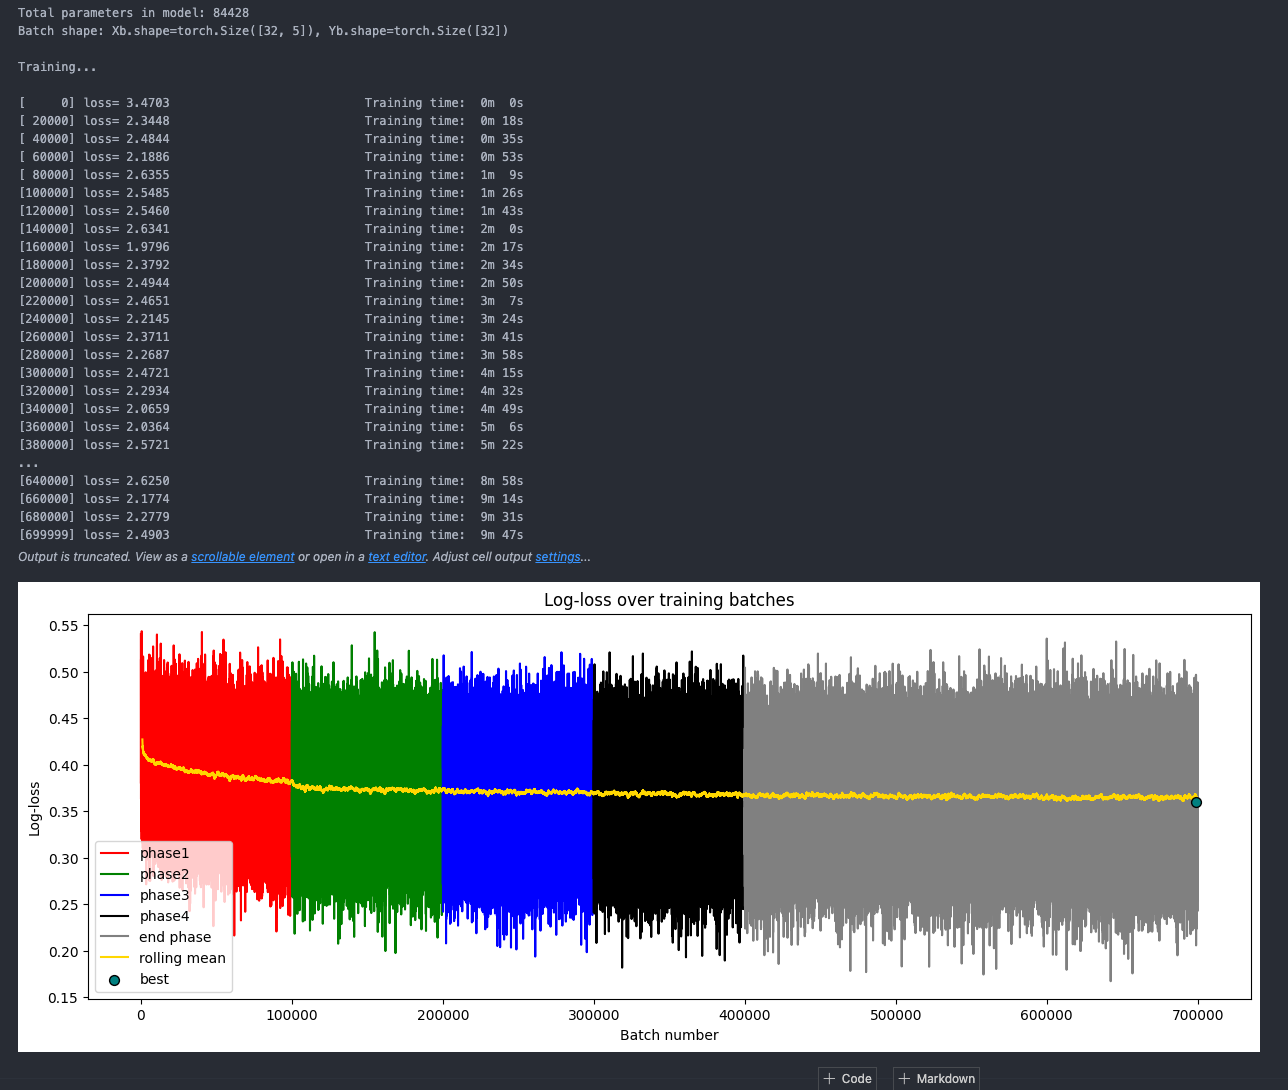

In [ ]:
for p, g in zip(parameters, grads):
    compare_gradients(str(tuple(p.shape)), g, p)


In [10]:
@torch.no_grad()
def split_loss(split: str) -> None:
    """compute and print the loss for the named split of the dataset: {train, val, test}."""
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]  # index into the embedding tensor at the position of the training indices

    # Compute the hidden layer transformation and apply non-linearity
    embcat = emb.view(emb.shape[0], WINDOW * embedding_dim)  # concatenate all the selected embedding vectors
    _h = embcat @ W1  # + b1  # before batch norm

    # Apply batch norm before applying non-linearity
    h_preact = bngain * (_h - bnmean_running) / (bnstd_running + EPS) + bnbias

    h = torch.tanh(h_preact)
    logits = h @ W2 + b2  # computes the output of our final hidden layer
    loss = F.cross_entropy(input=logits, target=y)  # Compute the loss (posed as binary classification)
    print(f"Full loss {split:<6} {loss:>8.6f}")


split_loss("train")
split_loss("val")
split_loss("test")

# Training with 20k parameters for 500k steps
# Full loss train  2.359250
# Full loss val    2.388760
# Full loss test   2.373373

# Training with 85k parameters for 700k steps
# Full loss train  2.304820
# Full loss val    2.348817
# Full loss test   2.336866

# Training with ~220k parameters for 700k steps on all characters, not only ascii
# Full loss train  2.378964
# Full loss val    2.441167
# Full loss test   2.425954

# Training with ~262k parameters for 800k steps on all characters, not only ascii
# Full loss train  2.202618
# Full loss val    2.382016
# Full loss test   2.367828


Full loss train  2.202618
Full loss val    2.382016
Full loss test   2.367828


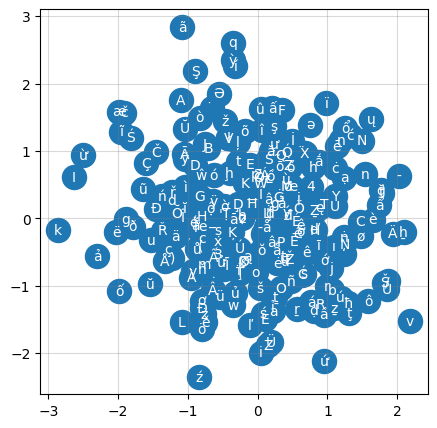

In [11]:
d1 = 0
d2 = 1
plt.figure(figsize=(5, 5))
plt.scatter(C[:, d1].data, C[:, d2].data, s=300)
for i in range(C.shape[0]):
    plt.text(C[i, d1].item(), C[i, d2].item(), s=itos[i], ha="center", va="center", color="white", size=10)

plt.grid(color="gray", alpha=0.3)


### Inference

In [ ]:
for i in range(20):
    ix = stoi[start_end_char]
    context = [ix] * WINDOW
    new_word = []

    while True:
        emb = C[torch.tensor([context])]  # shape (1, window, embedding)  (1, 5, 2)

        # Compute the hidden layer transformation and apply non-linearity
        embcat = emb.view(emb.shape[0], WINDOW * embedding_dim)  # concatenate all the selected embedding vectors
        _h = embcat @ W1  # + b1  # before batch norm
        # Apply batch norm before applying non-linearity
        h_preact = bngain * (_h - bnmean_running) / (bnstd_running + EPS) + bnbias

        h = torch.tanh(h_preact)
        logits = h @ W2 + b2  # computes the output of our final hidden layer

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        ch = itos[ix]
        if ch == start_end_char:
            break
        new_word.append(ch)
        context = context[1:] + [ix]

    gen_city = "".join(new_word)
    print(f"[Word {i:>2}]: {gen_city:<20} -- in dataset: {(gen_city + start_end_char) in cities}")


### Batched matrix multiplication

There are several matmul ops in for pytorch tensors:

1. `torch.mmul(a, b)`
2. `a @ b`
3. ...

In [3]:
a = torch.arange(24).view(2, 3, 4)
b = torch.arange(24, 0, step=-1).view(2, 4, 3)
a.shape, b.shape


(torch.Size([2, 3, 4]), torch.Size([2, 4, 3]))

In [121]:
res = a @ b
res.shape, res


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x1 and 3x3)

In [114]:
res = torch.matmul(a, b)
res.shape, res


(torch.Size([3]), tensor([12,  9,  6]))

In [117]:
res = torch.matmul(b, a.mT)
res.shape, res


RuntimeError: tensor.mT is only supported on matrices or batches of matrices. Got 1-D tensor.

In [10]:
l = torch.nn.Linear(4, 5)
a = a.float()
a, a.shape # (2, 3, 4)



(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.]],
 
         [[12., 13., 14., 15.],
          [16., 17., 18., 19.],
          [20., 21., 22., 23.]]]),
 torch.Size([2, 3, 4]))

In [13]:
l(a.permute(1, 0, 2))

tensor([[[ -2.0680,  -0.8209,  -0.4594,   0.6966,  -1.2949],
         [-12.7021,  -0.2340,  -2.0190,  -5.7945,  -1.2099]],

        [[ -5.6127,  -0.6253,  -0.9793,  -1.4671,  -1.2666],
         [-16.2468,  -0.0383,  -2.5388,  -7.9582,  -1.1815]],

        [[ -9.1574,  -0.4296,  -1.4991,  -3.6308,  -1.2382],
         [-19.7915,   0.1573,  -3.0586, -10.1219,  -1.1532]]],
       grad_fn=<AddBackward0>)

In [111]:
res = torch.mm(a, b)
res.shape, res


RuntimeError: self must be a matrix

### Applying mask to block history in batched attention layer

In [82]:
a = torch.randn(5, 5)
b = a.clone()
mask = torch.tril(torch.ones_like(a), diagonal=0)

a, b, mask


(tensor([[-1.2787, -0.7111, -0.3011,  2.2306,  0.5561],
         [ 0.9583,  0.2734, -1.1855,  1.2254, -0.0459],
         [ 1.0108,  0.2970,  0.1502, -1.6885,  0.2578],
         [-1.4379, -0.1343, -0.9427, -0.0027,  0.8937],
         [ 0.1571,  0.0069,  0.5062, -0.0353, -1.1258]]),
 tensor([[-1.2787, -0.7111, -0.3011,  2.2306,  0.5561],
         [ 0.9583,  0.2734, -1.1855,  1.2254, -0.0459],
         [ 1.0108,  0.2970,  0.1502, -1.6885,  0.2578],
         [-1.4379, -0.1343, -0.9427, -0.0027,  0.8937],
         [ 0.1571,  0.0069,  0.5062, -0.0353, -1.1258]]),
 tensor([[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]))

In [84]:
a_ = a.masked_fill(mask == 0, float("-inf"))
a_


tensor([[-1.2787,    -inf,    -inf,    -inf,    -inf],
        [ 0.9583,  0.2734,    -inf,    -inf,    -inf],
        [ 1.0108,  0.2970,  0.1502,    -inf,    -inf],
        [-1.4379, -0.1343, -0.9427, -0.0027,    -inf],
        [ 0.1571,  0.0069,  0.5062, -0.0353, -1.1258]])

In [85]:
b.masked_fill_(mask == 0.0, float("-inf"))
b


tensor([[-1.2787,    -inf,    -inf,    -inf,    -inf],
        [ 0.9583,  0.2734,    -inf,    -inf,    -inf],
        [ 1.0108,  0.2970,  0.1502,    -inf,    -inf],
        [-1.4379, -0.1343, -0.9427, -0.0027,    -inf],
        [ 0.1571,  0.0069,  0.5062, -0.0353, -1.1258]])

In [73]:
%timeit a.masked_fill_(mask == 0, float("-inf"))

3.27 µs ± 52.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [72]:
%timeit a.masked_fill(mask == 0, float("-inf"))

4.44 µs ± 42.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
